In [50]:
import math
import pandas as pd
from config_xgb import (
    GROUP_NAMES,
    FEATS,
    LABEL,
    CATEGORICAL_FEATS,
    FEATS_TO_ENCODE,
    DATE_FEATS,
    TARGET_METRICS,
    FEATS_TO_DISCARD,
)
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics._scorer import make_scorer
import numpy as np
from loguru import logger
import matplotlib.pyplot as plt
from scipy.stats import randint

from utils import SpaceTimeSplits, preprocess_feats
from metrics import get_metrics

### Load model (xgb trained on 133 feats with all types included)

In [2]:
xgb_130feats = xgb.XGBRegressor()
xgb_130feats.load_model("../saved_models/xgb_optuna_133feats_incltype.txt")

### test data prep

In [3]:
pd.options.mode.chained_assignment = None

TO_NORM_FEATS = True # set to True to normalize features
TO_NORM_LABELS = False # set to True to normalize labels
TO_REMOVE_INC_COLS = True
TO_REMOVE_INC_ROWS = False
IS_PRED_EXP = False  # Set to True to directly predict TSS as np.exp(value). otherwise, estimate the ln of the actual TSS value and just modify for measuring metrics


CV_FOLDS = 3
train_data = pd.read_csv("D:/Research/AIST/data/train_raw.csv")
train_data_raw = train_data.copy()
val_data = pd.read_csv("D:/Research/AIST/data/test_raw.csv")

if "Unnamed: 0" in train_data.columns:
    train_data = train_data.drop("Unnamed: 0", axis=1)
# Replace missing values with mean (using only training data)
for col in train_data.columns:
    if col in DATE_FEATS:
        continue
    if col in CATEGORICAL_FEATS:
        continue
    if col in FEATS_TO_DISCARD:
        continue
    col_mean = train_data[col].mean()
    train_data[col] = train_data[col].replace(np.nan, col_mean)
    val_data[col] = val_data[col].replace(np.nan, col_mean)


train_data, x_test, label_mu, label_sigma = preprocess_feats(
    train_data,
    val_data,
    label=LABEL,
    feats_to_encode=FEATS_TO_ENCODE,
    feats_to_discard=FEATS_TO_DISCARD+DATE_FEATS,
    group_names=GROUP_NAMES,
    to_remove_incomplete_cols=TO_REMOVE_INC_COLS,
    to_remove_rows_w_invalid_vals=TO_REMOVE_INC_ROWS,
    to_norm_feats=TO_NORM_FEATS,
    to_norm_labels=TO_NORM_LABELS,
)

x, y, groups = train_data[FEATS], train_data[LABEL], train_data_raw[GROUP_NAMES]
x_test, y_test = x_test[FEATS], x_test[LABEL]
y_test = np.exp(y_test) # need to np.exp since getting from raw values

if "index" in train_data.columns:
    train_data = train_data.drop("index", axis=1)
if "index" in x_test.columns:
    x_test = x_test.drop("index", axis=1)

C:\Users\Zhang\AppData\Local\Temp\ipykernel_36232\1292708273.py:11: DtypeWarning: Columns (176,180,182) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("D:/Research/AIST/data/train_raw.csv")
2022-12-03 19:29:44.384 | DEBUG    | utils:preprocess_feats:22 - Removing the ff columns: ['Unnamed: 0', 'COMID', '.partitions', 'julian', 'space_group', 'lat_group', 'long_group', 'time_group', 'mag', 'SiteID', 'endtime', 'date', 'date_utc', 'time', 'landsat_id', 'hexcolor', 'uniqueID', 'n', 'rn', 'FTYPE_lake', 'ftype_lake', '', 'HWTYPE', 'HWNodeSqKM', 'TOT_EVI_AMJ_2012', 'dswe', 'source', 'characteristicName', 'parameter', 'harmonized_unit', 'date_only', 'TZID', 'hillshadow', 'NS_NR', 'StartFlag', 'VPUIn', 'MAXELEVRAW', 'Enabled', 'TOT_ECOL3_30', 'TOT_ECOL3_31', 'TOT_S1720', 'TOT_ECOL3_34', 'ACC_ECOL3_30', 'ACC_ECOL3_31', 'ACC_ECOL3_34', 'analytical_method', 'GNIS_ID', 'GNIS_NAME', 'RPUID', 'VPUID', 'gnis_name_lake', '', ' ', 'date_unity', 'FDA

In [17]:
test_pred = xgb_130feats.predict(x_test[:10])
test_pred = np.round(np.exp(test_pred),2)
print(test_pred)

[ 4.53  9.91 17.52 17.69 50.36 71.82 12.    9.67  6.14  2.34]


### comparing pred and true avg TSS values for the different types

In [41]:
x_lake =  x_test.loc[x_test['type_Lake'] == 1]
x_stream = x_test.loc[x_test['type_Stream'] == 1]
x_estuary = x_test.loc[x_test['type_Estuary'] == 1]
x_facility = x_test.loc[x_test['type_Facility'] == 1]

lake_pred = np.round(np.exp(xgb_130feats.predict(x_lake)),2)
stream_pred = np.round(np.exp(xgb_130feats.predict(x_stream)),2)
estuary_pred = np.round(np.exp(xgb_130feats.predict(x_estuary)),2)
facility_pred = np.round(np.exp(xgb_130feats.predict(x_facility)),2)

x_axis = ["Lake", "Stream", "Estuary", "Facility"]
pred_averages = [np.average(lake_pred), np.average(stream_pred), np.average(estuary_pred), np.average(facility_pred)]
pred_vars = [np.var(lake_pred), np.var(stream_pred), np.var(estuary_pred), np.var(facility_pred)]

print("Lake pred avg TSS: ", pred_averages[0], "pred Variance: ", pred_vars[0])
print("Stream pred avg TSS: ", pred_averages[1], "pred Variance: ", pred_vars[1])
print("Estuary pred avg TSS: ", pred_averages[2], "pred Variance: ", pred_vars[2])
print("Facility pred avg TSS: ", pred_averages[3], "pred Variance: ", pred_vars[3])

Lake pred avg TSS:  11.703561 pred Variance:  212.20241
Stream pred avg TSS:  29.404556 pred Variance:  7630.826
Estuary pred avg TSS:  15.533074 pred Variance:  99.42423
Facility pred avg TSS:  18.664375 pred Variance:  127.28906


In [42]:
streams = val_data.loc[val_data['type'] == "Stream"]
estuaries = val_data.loc[val_data['type'] == "Estuary"]
lakes = val_data.loc[val_data['type'] == "Lake"]
facilities = val_data.loc[val_data['type'] == "Facility"]

streams_vals = np.round(np.exp(streams['value'].to_numpy()),2)
estuaries_vals = np.round(np.exp(estuaries['value'].to_numpy()),2)
lakes_vals = np.round(np.exp(lakes['value'].to_numpy()),2)
facilities_vals = np.round(np.exp(facilities['value'].to_numpy()),2)

true_averages = [np.average(lakes_vals), np.average(streams_vals), np.average(estuaries_vals), np.average(facilities_vals)]
true_vars = [np.var(lakes_vals), np.var(streams_vals), np.var(estuaries_vals), np.var(facilities_vals)]

print("Lake avg TSS: ", true_averages[0], "Variance: ", true_vars[0])
print("Stream avg TSS: ", true_averages[1], "Variance: ", true_vars[1])
print("Estuary avg TSS: ", true_averages[2], "Variance: ", true_vars[2])
print("Facility avg TSS: ", true_averages[3], "Variance: ", true_vars[3])



Lake avg TSS:  14.232855464159812 Variance:  442.31828338569
Stream avg TSS:  35.029978463747305 Variance:  11676.265298133061
Estuary avg TSS:  19.103074501573975 Variance:  383.1893037688462
Facility avg TSS:  28.26875 Variance:  1378.3133984375002


this graph just shows that the different types have noticeably different TSS averages 

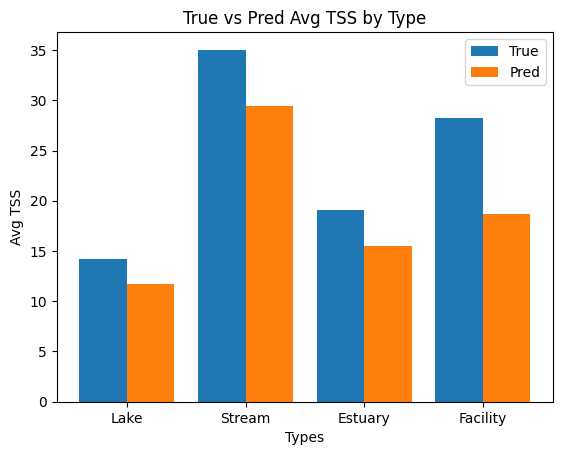

In [46]:
X_axis = np.arange(len(x_axis))

plt.bar(X_axis - 0.2, true_averages, 0.4, label = 'True')
plt.bar(X_axis + 0.2, pred_averages, 0.4, label = 'Pred')
  
plt.xticks(X_axis, x_axis)
plt.xlabel("Types")
plt.ylabel("Avg TSS")
plt.title("True vs Pred Avg TSS by Type")
plt.legend()
plt.show()

this graph is not very informative other than showing stream variance is much higher than the rest (log y axis!) 

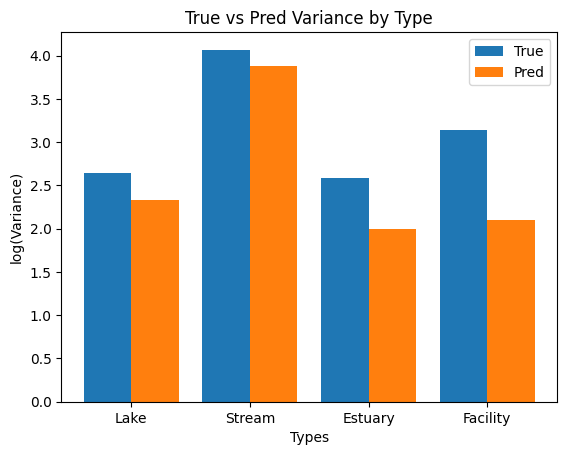

In [51]:
X_axis = np.arange(len(x_axis))

plt.bar(X_axis - 0.2, [math.log(y,10) for y in true_vars], 0.4, label = 'True')
plt.bar(X_axis + 0.2, [math.log(y,10) for y in pred_vars], 0.4, label = 'Pred')
  
plt.xticks(X_axis, x_axis)
plt.xlabel("Types")
plt.ylabel("log(Variance)")
plt.title("True vs Pred Variance by Type")
plt.legend()
plt.show()